<a href="https://colab.research.google.com/github/Vasco2510/AED_UTEC_MDZ/blob/main/DL_audio_classifier_w_tf_yt_tuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Install dependencies

In [ ]:
# 1.1 Instalación de dependencias. No trabajamos con tensorflor-io
!pip install tensorflow matplotlib pandas

# 1.2 Importaciones Estándar 2025/2026
import os
from matplotlib import pyplot as plt
import tensorflow as tf

# Keras 3 es el estándar actual, integrado en TensorFlow
from tensorflow.keras import models, layers, metrics

# Verificación de Hardware
print(f"Versión de TensorFlow: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detectada y lista: {gpus[0]}")
else:
    print("GPU no detectada. El entrenamiento será más lento en CPU.")

Versión de TensorFlow: 2.19.0
GPU detectada y lista: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 2 Build data loading function

## 2.1 Define paths to files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = '/content/drive/MyDrive' ## Posicionas en mi unidad

CAPUCHIN_FILE = os.path.join(BASE_DIR, 'proyectos_utec','DL_250', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav') ## desde mi unidad, entro a cada capeta
NOT_CAPUCHIN_FILE = os.path.join(BASE_DIR, 'proyectos_utec','DL_250', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
CAPUCHIN_FILE ## CORROBORADO que es adrres correcta.

'/content/drive/MyDrive/proyectos_utec/DL-250/Parsed_Capuchinbird_Clips/XC3776-3.wav'

## 2.2 Define load function

In [ ]:
def load_wav_16k_mono(filename):
    """
    Carga un archivo WAV, lo convierte a mono y lo remuestrea a 16kHz
    usando únicamente funciones nativas de TensorFlow.
    """
    # 1. Leer el archivo binario
    file_contents = tf.io.read_file(filename)

    # 2. Decodificar audio (desired_channels=1 asegura que sea MONO)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    # 3. Eliminar la dimensión extra: Osea sucede que [muestras, 1] -> [muestras]
    wav = tf.squeeze(wav, axis=-1)

    # 4. RESAMPLING ESTÁNDAR. Modificacion ante incompatibilidad de tensorflow-io
    # Convertimos a 16000Hz usando interpolación
    target_rate = 16000
    current_rate = tf.cast(sample_rate, dtype=tf.float32)

    # Calculamos el nuevo número de muestras
    num_samples = tf.cast(tf.shape(wav)[0], tf.float32)
    new_num_samples = tf.cast(num_samples * (target_rate / current_rate), tf.int32)

    # Reshape para tratar el audio como una imagen 1D (Batch, Height, Width, Channels)
    wav_4d = tf.reshape(wav, [1, -1, 1, 1])
    resampled_wav = tf.image.resize(wav_4d, [new_num_samples, 1])

    # Volvemos a la forma original [muestras]
    final_wav = tf.squeeze(resampled_wav)

    return final_wav

## 2.3 Get the wave forms

In [ ]:
# Prueba de la función
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

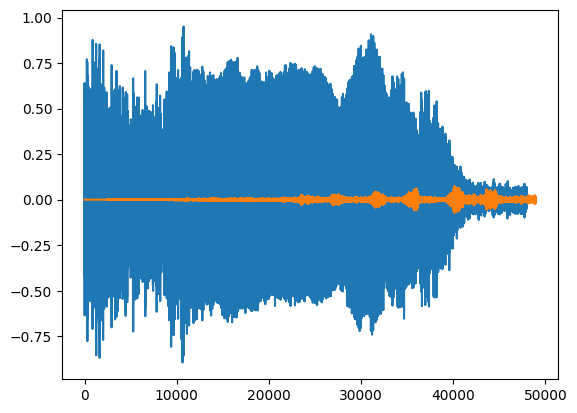

In [ ]:
plt.plot(wave)
plt.plot(nwave)


# create tensorflow dataset

Esta seccion crearemos nuestro propio dataset.

## 3.1 Defining paths to positive and negative data

In [ ]:
POS_DIR = os.path.join(BASE_DIR, 'proyectos_utec','DL_250', 'Parsed_Capuchinbird_Clips')
NEG_DIR = os.path.join(BASE_DIR, 'proyectos_utec', 'DL_250', 'Parsed_Not_Capuchinbird_Clips')


## 3.2 Cargar los archivos para positivo y para negativos



In [ ]:
pos_pattern = os.path.join(POS_DIR, '*.wav') ## COMPATIBLIDAD DE ACCESO CON W Y LINUX
neg_pattern = os.path.join(NEG_DIR, '*.wav')

In [ ]:
pos = tf.data.Dataset.list_files(pos_pattern)
neg = tf.data.Dataset.list_files(neg_pattern)

In [ ]:
# Verificación de cantidad (Estándar moderno para inspeccionar datasets)
print(f"Archivos positivos encontrados: {len(pos)}")
print(f"Archivos negativos encontrados: {len(neg)}")

Archivos positivos encontrados: 217
Archivos negativos encontrados: 593


Observamos que, la data esta desbalanceada:
Archivos positivos encontrados: 217
Archivos negativos encontrados: 593


## 3.3 Labelear los archivos

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

# Concatenamos ambos datasets en uno solo
data = positives.concatenate(negatives)

# Verificamos un elemento aleatorio del dataset fusionado
example_path, example_label = data.as_numpy_iterator().next() # para que sirve esto?
print(f"Ruta ejemplo: {example_path.decode('utf-8')}")
print(f"Etiqueta: {example_label}")

Ruta ejemplo: /content/drive/MyDrive/proyectos_utec/DL-250/Parsed_Capuchinbird_Clips/XC227468-0.wav
Etiqueta: 1.0


# 4. EDA del dataset
realizar un minimo analisis exploratorio

In [ ]:
lengths = []

for file in os.listdir(POS_DIR):
  tensor_wave = load_wav_16k_mono(os.path.join(POS_DIR,file)) ## explicar
  lengths.append(len(tensor_wave))

print(f"Procesados {len(lengths)} archivos para nalisis") # structure : python variable commment

Procesados 217 archivos para nalisis


Longitud Mínima: 32000 muestras
Longitud Máxima: 80000 muestras
Longitud Media:  54156 muestras
Media en segundos: 3.38s


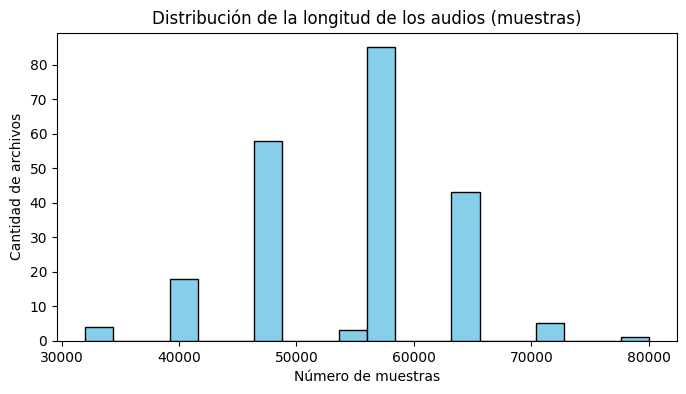

In [ ]:
# Calculamos estadísticas básicas usando TensorFlow
mean_len = tf.math.reduce_mean(lengths)
min_len = tf.math.reduce_min(lengths)
max_len = tf.math.reduce_max(lengths)

print(f"Longitud Mínima: {min_len} muestras")
print(f"Longitud Máxima: {max_len} muestras")
print(f"Longitud Media:  {mean_len} muestras")

# Cálculo en segundos (recordando que nuestra frecuencia es 16,000Hz)
print(f"Media en segundos: {mean_len/16000:.2f}s")

# Visualización CS: Histograma de duraciones
plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribución de la longitud de los audios (muestras)")
plt.xlabel("Número de muestras")
plt.ylabel("Cantidad de archivos")
plt.show()

# 5. Build the spectrograms

## 5.1 Funcion de preprocesamietno

In [ ]:
# CHUNK 8: Conversión de Audio a Espectrograma (Pipeline Nativo)
# ======================================================================

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)

    # 2. Estandarización de longitud (Padding / Truncating)
    # Queremos exactamente 48,000 muestras (3 seg a 16kHz)
    wav = wav[:48000] # Truncamos si es más largo
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0) # Rellenamos con ceros si es más corto

    # 3. Short-Time Fourier Transform (STFT)
    # frame_length: tamaño de la ventana de análisis
    # frame_step: cuánto avanza la ventana (determina el solapamiento)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)

    # 4. Obtener la magnitud (valor absoluto)
    # El STFT devuelve números complejos; necesitamos su magnitud real.
    spectrogram = tf.abs(spectrogram)

    # 5. Añadir dimensión de canal (Requerido para Conv2D: Altura, Ancho, Canales)
    # Convertimos de (muestras, frecuencias) a (muestras, frecuencias, 1)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    return spectrogram, label

## 5.2 visualizacion espectrograma

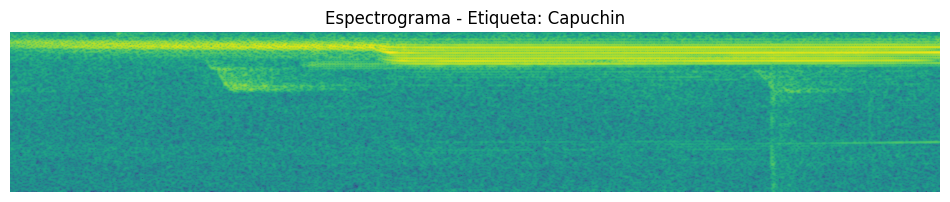

In [ ]:
# CHUNK 9: Prueba y Visualización del Espectrograma
# ======================================================================

# Tomamos un ejemplo positivo del dataset que creamos en la Sección 3
filepath, label = positives.as_numpy_iterator().next()

# Procesamos
spectrogram, label = preprocess(filepath, label)

plt.show()

# 6. Create Training and testing Partitions

## 6.1 Create a Tensorflow data pipeline